# CNNbasic Assignment#2

# AlexNet 구현

모델 구현 후 summary로 전체 모델 구조 출력과 주석으로 간단한 설명을 달아주시면 됩니다.

프레임워크는 자유이고, 기본 tensforflow와 pytorch tutorial 사이트를 아래에 첨부해 드립니다.

이 외 각 프레임워크 별 summary 등 추가적인 사용 방법은 구글링으로 찾아주세요!-!

- Tensorflow Tutorial: https://www.tensorflow.org/tutorials?hl=ko

- Pytorch Tutorial: https://tutorials.pytorch.kr/


## Tensorflow(keras)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense
from tensorflow.keras.models import Sequential


n_classes = 1000 # class 개수

model=Sequential()

############## Add Layer ##############

model.add(????) 

#######################################

# keras summary
???? # summary code 추가

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       8

## Pytorch

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [47]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class AlexNet(nn.Module):

    def __init__(self, n_classes=10):
        super(AlexNet, self).__init__()
        #input size : b x 3 x 227 x 227  --> MNIST 데이터에 적용할 거라 input channel이 1로 바뀜
        
        self.conv1 = nn.Sequential(
        
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0), 
            nn.ReLU(), # 96x55x55
            nn.MaxPool2d(kernel_size=3, stride=2) 
        ) 
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2), # in_channels: 96, out_channels: 256, kernel_size=5x5, stride=1, padding=2
            nn.ReLU(),
            nn.MaxPool2d(3, 2) 
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU() 
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU() 
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2) 
        )
        
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x): # input size = 3x227x227
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out) # 64x4096x1x1
        out = out.view(out.size(0), -1) # 64x4096
        
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        
        return out


# pytorch summary
model = AlexNet().to(device)
summary(model, input_size=(1, 227, 227), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Linear-14                 [-

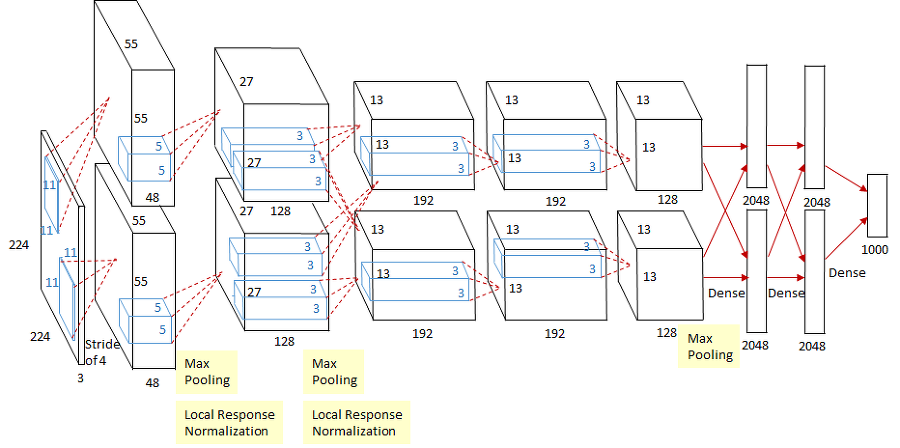

###모델 학습 (MNIST data 활용)

데이터 불러오기

In [48]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torchvision 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader

In [49]:
epochs = 3
batch_size = 512

In [50]:
transform = transforms.Compose([
    transforms.Resize(227), #mnist 이미지의 크기가 28*28 이므로 227*227 형태도 resizing 해준다
    transforms.ToTensor() #PIL 이미지 혹은 numpy.ndarray를 tensor 형태로 변환한다
])

training_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=transform
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [51]:
#dataloader : data를 batch 단위로 모델에 넣어주는 역할을 한다.

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

In [52]:
for x,y in training_loader:
    print(x.shape)
    print(y.shape)
    break

for x,y in validation_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 1, 227, 227])
torch.Size([64])
torch.Size([64, 1, 227, 227])
torch.Size([64])


이미지 확인

Shirt


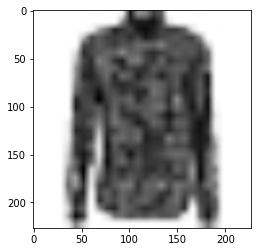

In [53]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개의 클래스
               
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
# get some random training images
dataiter = iter(training_loader) 
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) 

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [54]:
criterion = F.nll_loss #negativd log likelihood loss
optimizer = optim.Adam(model.parameters())

train 및 test 함수 정의



In [55]:
def train(model, device, train_loader, optimizer, epoch) :
  model.train()

  #training step
  for batch_idx, (data, target) in enumerate(train_loader):
    target = target.type(torch.LongTensor)
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() #back propagation 전 gradient를 0으로 초기화해줘야 한다.

    #forward + back propagation + loss
    output = model(data)
    loss = criterion(output, target)
    loss.backward()

    #model parameter update
    optimizer.step()
    if (batch_idx+1) % 30 == 0:
      print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [56]:
def test(model, device, test_loader) :
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader :
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    print('='*50)

###학습

In [58]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: 1.006354
Train Epoch:1 [3776/60000 (6%)]	Loss: 0.368674
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.600390
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.659431
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.496716
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.703650
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.567223
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.467148
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.355519
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.410900
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.400810
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.416193
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.617366
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.476482
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.530034
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.507716
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.289299
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.541364
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.354963
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.419959
Train Epoch:1 [40256/60000 (

KeyboardInterrupt: ignored

시간관계상 에포크 1개만 학습을 시켰다. 정확도는 다음과 같다 : 86%